1. 성능평가지표 f1, AUC O
2. voting(soft) x
3. quantization o
4. cnn 계열 모델(densenet, inception-v3, resnet18, 34, 50) o
5. scheduler(reduceLRonPlateau) o
6. 증강 x
ppt
1.스팩트로그램 변환 o
2.split(val) o


grid-search
ablation=optuna

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 압축 해제 명령
!unzip -qq "/content/drive/MyDrive/dataset.zip" -d dataset

In [ ]:
# 압축 해제 명령
!unzip -qq "/content/drive/MyDrive/Dataset_spec.zip" -d dataset1

In [ ]:
!ls /content/dataset1/train_spec/non-violence

'아들맘은 역시 현명해 😇 #101호 #101호하윤맘_[cut_10sec]_[cut_10sec]_part0.png'
'아들맘은 역시 현명해 😇 #101호 #101호하윤맘_[cut_10sec]_[cut_10sec]_part1.png'
'아들맘은 역시 현명해 😇 #101호 #101호하윤맘_[cut_10sec]_[cut_10sec]_part2.png'
'아들맘은 역시 현명해 😇 #101호 #101호하윤맘_[cut_10sec]_[cut_10sec]_part3.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part0.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part10.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part11.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part12.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part13.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part14.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part15.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part16.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part17.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part18.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part19.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part1.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part20.png'
'1시간 영어 듣기 연습 2023년편 - 파트 4_[cut_119sec]_part21.png'


In [ ]:
pip install librosa matplotlib

In [ ]:
pip install scikit-learn

In [ ]:
# torch 관련 라이브러리
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchsummary import summary
import torchaudio.transforms as T

# 일반 라이브러리
import argparse
import numpy as np
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import f1_score

 #스팩트로그램
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from PIL import Image

# 스케쥴러, AUC
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
# 모델 학습 관련 파라미터 모음 --> 자유롭게 변경하고, 추가해보세요.

class Args():
  data_type = "2d"
  scheduler = "reducelronplateau"
  model = "resnet"
  n_class = 2
  epoch = 50
  phase = "train"
  model_path = "./model_weight_2d.pth"

args = Args()


In [ ]:
# 데이터 세트 관련 함수 --> 데이터 증강 기법을 적절하게 추가해보세요.
class TimeMasking(object):
    def __init__(self, T=40, max_masks=1):
        self.T = T
        self.max_masks = max_masks

    def __call__(self, spec):
        for _ in range(0, self.max_masks):
            t = random.randrange(0, self.T)
            t0 = random.randrange(0, spec.shape[1] - t)
            spec[:, t0:t0+t] = 0
        return spec

class FrequencyMasking(object):
    def __init__(self, F=30, max_masks=1):
        self.F = F
        self.max_masks = max_masks

    def __call__(self, spec):
        for _ in range(0, self.max_masks):
            f = random.randrange(0, self.F)
            max_f0 = spec.shape[0] - f
            if max_f0 <= 0:
                continue
            f0 = random.randrange(0, max_f0)
            spec[f0:f0+f, :] = 0
        return spec

class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.classes = sorted(os.listdir(directory))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []


        for class_name in self.classes:
            class_dir = os.path.join(directory, class_name)
            for image_name in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, image_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습용 데이터셋 및 데이터 로더
train_dataset = ImageDataset('/content/dataset1/train_spec', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# 검증용 데이터셋 및 데이터 로더
val_dataset = ImageDataset('/content/dataset1/validation_spec', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# 학습용 데이터셋의 크기 출력
print(f"학습 데이터 수는 {len(train_dataset)}개 입니다.")

# 검증용 데이터셋의 크기 출력
print(f"검증 데이터 수는 {len(val_dataset)}개 입니다.")

학습 데이터 수는 1846개 입니다.
검증 데이터 수는 614개 입니다.


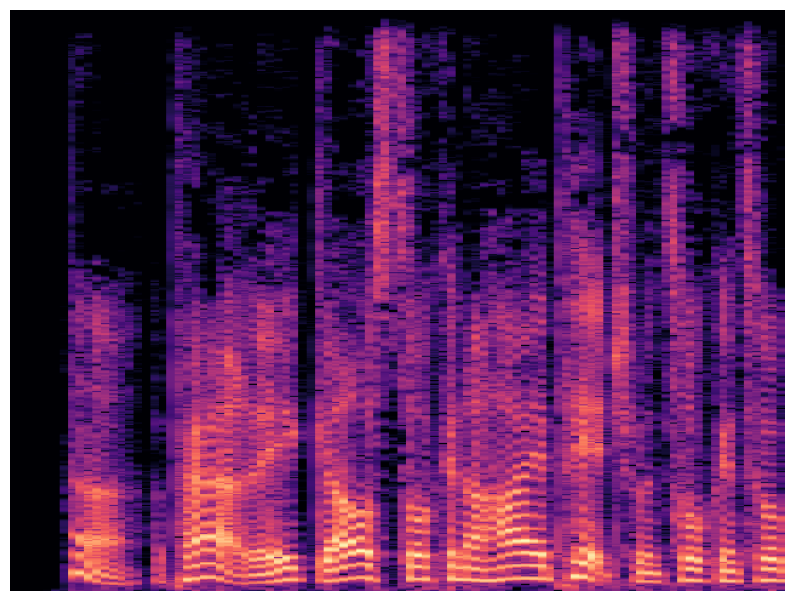

In [ ]:
# 이미지 파일 경로
image_path = '/content/dataset1/test_spec/non-violence/Talking to girls…_part0.png'

# 이미지 열기
image = Image.open(image_path)

# 이미지 시각화
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # 축 표시 안함
plt.show()

In [ ]:
def get_model(name, n_class, pretrained=True): # pretrained는 항상 False로 두어야 합니다. True로 학습할 경우 감점(-5)
    if name == 'vgg16':
        model = models.vgg16(pretrained=pretrained)
        #num_features = model.classifier[2].in_features
        #model.classifier[2] = nn.Linear(num_features, n_class)
    elif name == 'resnet':
        model = models.resnet18(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, n_class)
    elif name == 'densenet':
        model = models.densenet121(pretrained=pretrained)
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, n_class)
    elif name == 'inception_v3':
        model = models.inception_v3(pretrained=pretrained)
        # Replace the classifier with a fully connected layer with n_class outputs
        model.fc = nn.Linear(model.fc.in_features, n_class)
    return model

resnet = get_model('resnet', args.n_class)
vgg16 = get_model('vgg16', args.n_class)
densenet = get_model('densenet', args.n_class)
inception_v3 = get_model('inception_v3', args.n_class)

import torch.nn as nn
import torch.nn.functional as F

# Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # 입력 크기를 맞추기 위한 downsample 레이어

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # 입력과 출력 더하기 (Residual 연결)
        out += identity
        out = F.relu(out)
        return out

# ResNet 기본 네트워크 정의
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # 초기 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet 레이어 쌓기
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Adaptive Pooling과 Fully Connected Layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            # 입력과 출력의 크기가 다를 경우 downsample을 사용하여 크기를 맞춤
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet18 구조로 모델 생성 (기본 레이어 블록 수)
def resnet18(num_classes=6):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

# 예시: ResNet18 모델 생성
model = resnet18(num_classes=6)


In [ ]:
# utils에 포함되었던 함수들 + tic toc 추가. tic toc은 수정하지마세요.
def visualize_audio_batch(audio_signals, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.flat):
        if i >= 16:  # 16개의 오디오만 표시
            break
        ax.plot(audio_signals[i].t().numpy())  # 오디오 신호 플롯
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def tic():
    # 현재 시간을 전역 변수에 저장
    global start_time
    start_time = time.time()

def toc():
    # tic()이 호출된 후 경과한 시간을 계산하고 출력
    elapsed_time = time.time() - start_time

    hours = int(elapsed_time // 3600)
    minutes = int((elapsed_time % 3600) // 60)
    seconds = elapsed_time % 60
    print(f"학습에 소요된 시간은 총 : {hours}시간 {minutes}분 {seconds}초 입니다.")

In [ ]:
def train_model(model, train_loader, val_loader, epochs, device, args):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

    if args.scheduler == 'multistep':
        scheduler = MultiStepLR(optimizer, milestones=[5, 10], gamma=0.1)
    elif args.scheduler == 'steplr':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    elif args.scheduler == 'reducelronplateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)
        correct_predictions = 0
        total_samples = 0
        all_labels = []
        all_predictions = []
        all_outputs = []

        for i, (audio_signals, labels) in enumerate(tqdm(train_loader)):
            audio_signals, labels = audio_signals.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(audio_signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_outputs.extend(outputs.detach().cpu().numpy())  # Use detach() before numpy()

        avg_loss = running_loss / total_batches
        accuracy = correct_predictions / total_samples
        train_f1_score = f1_score(all_labels, all_predictions, average='weighted')

        try:
            train_auc = roc_auc_score(all_labels, all_outputs, multi_class='ovr')
        except ValueError:
            train_auc = None  # Handle the case when AUC cannot be computed

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}, Train F1 Score: {train_f1_score:.4f}, Train AUC: {train_auc}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        all_val_labels = []
        all_val_predictions = []
        all_val_outputs = []

        with torch.no_grad():
            for audio_signals, labels in tqdm(val_loader):
                audio_signals, labels = audio_signals.to(device), labels.to(device)

                outputs = model(audio_signals)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_predictions.extend(predicted.cpu().numpy())
                all_val_outputs.extend(outputs.detach().cpu().numpy())  # Use detach() before numpy()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples
        val_f1_score = f1_score(all_val_labels, all_val_predictions, average='weighted')

        try:
            val_auc = roc_auc_score(all_val_labels, all_val_outputs, multi_class='ovr')
        except ValueError:
            val_auc = None  # Handle the case when AUC cannot be computed

        print(f"Epoch [{epoch + 1}/{epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1_score:.4f}, Val AUC: {val_auc}")

        # Scheduler update
        if args.scheduler == 'reducelronplateau':
            scheduler.step(avg_val_loss)
        else:
            scheduler.step()

    print('Finished Training')

    # Save the model
    torch.save(model.state_dict(), f"./model_weight_{args.data_type}.pth")
    return model


In [ ]:
# 모델 불러오기
if args.data_type == "1d":
    model = resnet18(num_classes=6)

elif args.data_type == "2d":
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        TimeMasking(T=40, max_masks=1),
        FrequencyMasking(F=30, max_masks=1)
    ])

    if args.model == 'vgg16':
        model = get_model(args.model, args.n_class, pretrained=False)
    elif args.model == 'resnet':
        model = get_model(args.model, args.n_class, pretrained=True)
        #quantized_model = torch.quantization.quantize_dynamic(
            #model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8
        #)
        #quantized_model.eval()
    elif args.model == 'densenet':
        model = get_model(args.model, args.n_class, pretrained=False)
        quantized_model = torch.quantization.quantize_dynamic(
            model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8
        )
        quantized_model.eval()
    elif args.model == 'inception_v3':
        model = get_model(args.model, args.n_class, pretrained=False)
        quantized_model = torch.quantization.quantize_dynamic(
            model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8
        )
        quantized_model.eval()
    elif args.model == 'simple':
        model = Simple2DCNN()

    train_dataset = ImageDataset(directory='/content/dataset1/train_spec', transform=transform)
    val_dataset = ImageDataset(directory='/content/dataset1/validation_spec', transform=transform)


# 데이터 로더 재생성
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(f"학습 데이터 수는 {len(train_dataset)}개 입니다.")
print(f"검증 데이터 수는 {len(val_dataset)}개 입니다.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
학습 데이터 수는 1846개 입니다.
검증 데이터 수는 614개 입니다.


In [ ]:
# 모델 요약
if args.data_type == "1d":
    summary(model.cuda(), (1,16000))
elif args.data_type == "2d":
    summary(model.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [32]:
# 학습 시작 및 종료에 걸린 시간을 측정하기 위한 tic - toc

tic()

model = train_model(model, train_loader, val_loader, epochs=args.epoch, device=device, args=args)

toc()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 923/923 [00:40<00:00, 22.73it/s]


Epoch [1/50], Train Loss: 0.8145, Train Accuracy: 0.5233, Train F1 Score: 0.5210, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.00it/s]


Epoch [1/50], Val Loss: 0.6941, Val Accuracy: 0.5163, Val F1 Score: 0.5212, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.69it/s]


Epoch [2/50], Train Loss: 0.7012, Train Accuracy: 0.5374, Train F1 Score: 0.5098, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 32.77it/s]


Epoch [2/50], Val Loss: 0.6639, Val Accuracy: 0.6059, Val F1 Score: 0.5591, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.55it/s]


Epoch [3/50], Train Loss: 0.6891, Train Accuracy: 0.5428, Train F1 Score: 0.4435, Train AUC: None


100%|██████████| 307/307 [00:10<00:00, 30.31it/s]


Epoch [3/50], Val Loss: 0.6638, Val Accuracy: 0.6026, Val F1 Score: 0.4532, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.92it/s]


Epoch [4/50], Train Loss: 0.6807, Train Accuracy: 0.5417, Train F1 Score: 0.5294, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.71it/s]


Epoch [4/50], Val Loss: 0.6796, Val Accuracy: 0.6026, Val F1 Score: 0.4532, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.27it/s]


Epoch [5/50], Train Loss: 0.6673, Train Accuracy: 0.5748, Train F1 Score: 0.5721, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 33.54it/s]


Epoch [5/50], Val Loss: 0.7118, Val Accuracy: 0.6580, Val F1 Score: 0.5756, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.09it/s]


Epoch [6/50], Train Loss: 0.5521, Train Accuracy: 0.7346, Train F1 Score: 0.7331, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.79it/s]


Epoch [6/50], Val Loss: 0.4931, Val Accuracy: 0.8127, Val F1 Score: 0.8107, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.56it/s]


Epoch [7/50], Train Loss: 0.6105, Train Accuracy: 0.6517, Train F1 Score: 0.6378, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 34.23it/s]


Epoch [7/50], Val Loss: 0.7037, Val Accuracy: 0.4837, Val F1 Score: 0.4882, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.26it/s]


Epoch [8/50], Train Loss: 0.6846, Train Accuracy: 0.5520, Train F1 Score: 0.5377, Train AUC: None


100%|██████████| 307/307 [00:10<00:00, 30.24it/s]


Epoch [8/50], Val Loss: 0.7039, Val Accuracy: 0.5619, Val F1 Score: 0.4575, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.08it/s]


Epoch [9/50], Train Loss: 0.6795, Train Accuracy: 0.5515, Train F1 Score: 0.5239, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 33.57it/s]


Epoch [9/50], Val Loss: 0.6248, Val Accuracy: 0.6026, Val F1 Score: 0.4561, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.63it/s]


Epoch [10/50], Train Loss: 0.4793, Train Accuracy: 0.7909, Train F1 Score: 0.7889, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.78it/s]


Epoch [10/50], Val Loss: 0.4493, Val Accuracy: 0.7964, Val F1 Score: 0.7821, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.73it/s]


Epoch [11/50], Train Loss: 0.4067, Train Accuracy: 0.8299, Train F1 Score: 0.8282, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 35.85it/s]


Epoch [11/50], Val Loss: 0.5231, Val Accuracy: 0.7720, Val F1 Score: 0.7507, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.84it/s]


Epoch [12/50], Train Loss: 0.4043, Train Accuracy: 0.8315, Train F1 Score: 0.8300, Train AUC: None


100%|██████████| 307/307 [00:10<00:00, 30.13it/s]


Epoch [12/50], Val Loss: 0.4569, Val Accuracy: 0.7850, Val F1 Score: 0.7650, Val AUC: None


100%|██████████| 923/923 [00:41<00:00, 22.39it/s]


Epoch [13/50], Train Loss: 0.3784, Train Accuracy: 0.8413, Train F1 Score: 0.8398, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 34.48it/s]


Epoch [13/50], Val Loss: 0.4076, Val Accuracy: 0.7964, Val F1 Score: 0.7777, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.30it/s]


Epoch [14/50], Train Loss: 0.3749, Train Accuracy: 0.8375, Train F1 Score: 0.8356, Train AUC: None


100%|██████████| 307/307 [00:10<00:00, 30.64it/s]


Epoch [14/50], Val Loss: 0.4336, Val Accuracy: 0.8127, Val F1 Score: 0.8015, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.32it/s]


Epoch [15/50], Train Loss: 0.3503, Train Accuracy: 0.8629, Train F1 Score: 0.8621, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 33.85it/s]


Epoch [15/50], Val Loss: 0.3462, Val Accuracy: 0.8583, Val F1 Score: 0.8557, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.08it/s]


Epoch [16/50], Train Loss: 0.3622, Train Accuracy: 0.8494, Train F1 Score: 0.8483, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.65it/s]


Epoch [16/50], Val Loss: 0.3872, Val Accuracy: 0.8404, Val F1 Score: 0.8347, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.87it/s]


Epoch [17/50], Train Loss: 0.3376, Train Accuracy: 0.8608, Train F1 Score: 0.8598, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 32.02it/s]


Epoch [17/50], Val Loss: 0.4149, Val Accuracy: 0.7980, Val F1 Score: 0.7812, Val AUC: None


100%|██████████| 923/923 [00:37<00:00, 24.38it/s]


Epoch [18/50], Train Loss: 0.3213, Train Accuracy: 0.8640, Train F1 Score: 0.8633, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.04it/s]


Epoch [18/50], Val Loss: 0.4316, Val Accuracy: 0.7915, Val F1 Score: 0.7710, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.33it/s]


Epoch [19/50], Train Loss: 0.3146, Train Accuracy: 0.8732, Train F1 Score: 0.8725, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 34.48it/s]


Epoch [19/50], Val Loss: 0.5799, Val Accuracy: 0.7524, Val F1 Score: 0.7223, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 23.01it/s]


Epoch [20/50], Train Loss: 0.3188, Train Accuracy: 0.8711, Train F1 Score: 0.8702, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.35it/s]


Epoch [20/50], Val Loss: 0.4877, Val Accuracy: 0.8420, Val F1 Score: 0.8383, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.12it/s]


Epoch [21/50], Train Loss: 0.2987, Train Accuracy: 0.8824, Train F1 Score: 0.8817, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.93it/s]


Epoch [21/50], Val Loss: 0.3787, Val Accuracy: 0.8404, Val F1 Score: 0.8368, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.53it/s]


Epoch [22/50], Train Loss: 0.2507, Train Accuracy: 0.9025, Train F1 Score: 0.9019, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.37it/s]


Epoch [22/50], Val Loss: 0.3813, Val Accuracy: 0.8160, Val F1 Score: 0.8064, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.86it/s]


Epoch [23/50], Train Loss: 0.2446, Train Accuracy: 0.9020, Train F1 Score: 0.9014, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.97it/s]


Epoch [23/50], Val Loss: 0.4390, Val Accuracy: 0.8420, Val F1 Score: 0.8393, Val AUC: None


100%|██████████| 923/923 [00:38<00:00, 23.82it/s]


Epoch [24/50], Train Loss: 0.2359, Train Accuracy: 0.9101, Train F1 Score: 0.9095, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.96it/s]


Epoch [24/50], Val Loss: 0.4400, Val Accuracy: 0.8355, Val F1 Score: 0.8310, Val AUC: None


100%|██████████| 923/923 [00:41<00:00, 22.50it/s]


Epoch [25/50], Train Loss: 0.2314, Train Accuracy: 0.9117, Train F1 Score: 0.9113, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.76it/s]


Epoch [25/50], Val Loss: 0.4447, Val Accuracy: 0.8225, Val F1 Score: 0.8145, Val AUC: None


100%|██████████| 923/923 [00:38<00:00, 23.68it/s]


Epoch [26/50], Train Loss: 0.2133, Train Accuracy: 0.9166, Train F1 Score: 0.9162, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 33.43it/s]


Epoch [26/50], Val Loss: 0.7046, Val Accuracy: 0.7948, Val F1 Score: 0.7878, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.13it/s]


Epoch [27/50], Train Loss: 0.2128, Train Accuracy: 0.9215, Train F1 Score: 0.9210, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.59it/s]


Epoch [27/50], Val Loss: 0.5423, Val Accuracy: 0.8339, Val F1 Score: 0.8309, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.66it/s]


Epoch [28/50], Train Loss: 0.2133, Train Accuracy: 0.9155, Train F1 Score: 0.9152, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 32.67it/s]


Epoch [28/50], Val Loss: 0.5223, Val Accuracy: 0.8306, Val F1 Score: 0.8265, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.25it/s]


Epoch [29/50], Train Loss: 0.2084, Train Accuracy: 0.9150, Train F1 Score: 0.9147, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.92it/s]


Epoch [29/50], Val Loss: 0.4646, Val Accuracy: 0.8339, Val F1 Score: 0.8299, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.58it/s]


Epoch [30/50], Train Loss: 0.2170, Train Accuracy: 0.9204, Train F1 Score: 0.9200, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 34.69it/s]


Epoch [30/50], Val Loss: 0.4562, Val Accuracy: 0.8290, Val F1 Score: 0.8248, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.21it/s]


Epoch [31/50], Train Loss: 0.2015, Train Accuracy: 0.9242, Train F1 Score: 0.9239, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.81it/s]


Epoch [31/50], Val Loss: 0.4439, Val Accuracy: 0.8616, Val F1 Score: 0.8592, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.37it/s]


Epoch [32/50], Train Loss: 0.2111, Train Accuracy: 0.9187, Train F1 Score: 0.9184, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 35.57it/s]


Epoch [32/50], Val Loss: 0.4848, Val Accuracy: 0.8355, Val F1 Score: 0.8317, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.17it/s]


Epoch [33/50], Train Loss: 0.2045, Train Accuracy: 0.9274, Train F1 Score: 0.9271, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.84it/s]


Epoch [33/50], Val Loss: 0.4768, Val Accuracy: 0.8469, Val F1 Score: 0.8445, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 23.00it/s]


Epoch [34/50], Train Loss: 0.2046, Train Accuracy: 0.9236, Train F1 Score: 0.9233, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 35.66it/s]


Epoch [34/50], Val Loss: 0.5350, Val Accuracy: 0.8046, Val F1 Score: 0.7982, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.22it/s]


Epoch [35/50], Train Loss: 0.1980, Train Accuracy: 0.9258, Train F1 Score: 0.9255, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.00it/s]


Epoch [35/50], Val Loss: 0.5116, Val Accuracy: 0.8290, Val F1 Score: 0.8248, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 23.01it/s]


Epoch [36/50], Train Loss: 0.2065, Train Accuracy: 0.9236, Train F1 Score: 0.9234, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 35.82it/s]


Epoch [36/50], Val Loss: 0.6457, Val Accuracy: 0.7932, Val F1 Score: 0.7866, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.15it/s]


Epoch [37/50], Train Loss: 0.2061, Train Accuracy: 0.9215, Train F1 Score: 0.9212, Train AUC: None


100%|██████████| 307/307 [00:10<00:00, 30.69it/s]


Epoch [37/50], Val Loss: 0.6048, Val Accuracy: 0.8094, Val F1 Score: 0.8052, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 23.04it/s]


Epoch [38/50], Train Loss: 0.2066, Train Accuracy: 0.9215, Train F1 Score: 0.9211, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 35.40it/s]


Epoch [38/50], Val Loss: 0.5552, Val Accuracy: 0.8176, Val F1 Score: 0.8102, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.25it/s]


Epoch [39/50], Train Loss: 0.2133, Train Accuracy: 0.9236, Train F1 Score: 0.9233, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.84it/s]


Epoch [39/50], Val Loss: 0.5834, Val Accuracy: 0.8046, Val F1 Score: 0.7956, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.11it/s]


Epoch [40/50], Train Loss: 0.2050, Train Accuracy: 0.9236, Train F1 Score: 0.9233, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 36.07it/s]


Epoch [40/50], Val Loss: 0.5645, Val Accuracy: 0.8192, Val F1 Score: 0.8147, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.97it/s]


Epoch [41/50], Train Loss: 0.2056, Train Accuracy: 0.9247, Train F1 Score: 0.9243, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 30.70it/s]


Epoch [41/50], Val Loss: 0.5742, Val Accuracy: 0.8371, Val F1 Score: 0.8346, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.86it/s]


Epoch [42/50], Train Loss: 0.1956, Train Accuracy: 0.9215, Train F1 Score: 0.9212, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 35.00it/s]


Epoch [42/50], Val Loss: 0.5836, Val Accuracy: 0.8339, Val F1 Score: 0.8301, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.28it/s]


Epoch [43/50], Train Loss: 0.2107, Train Accuracy: 0.9139, Train F1 Score: 0.9136, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.18it/s]


Epoch [43/50], Val Loss: 0.5437, Val Accuracy: 0.8208, Val F1 Score: 0.8165, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.14it/s]


Epoch [44/50], Train Loss: 0.2147, Train Accuracy: 0.9150, Train F1 Score: 0.9146, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 33.70it/s]


Epoch [44/50], Val Loss: 0.5168, Val Accuracy: 0.8453, Val F1 Score: 0.8417, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.52it/s]


Epoch [45/50], Train Loss: 0.2051, Train Accuracy: 0.9247, Train F1 Score: 0.9244, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.35it/s]


Epoch [45/50], Val Loss: 0.5947, Val Accuracy: 0.8143, Val F1 Score: 0.8086, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 23.04it/s]


Epoch [46/50], Train Loss: 0.1983, Train Accuracy: 0.9274, Train F1 Score: 0.9272, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 32.52it/s]


Epoch [46/50], Val Loss: 0.5389, Val Accuracy: 0.8371, Val F1 Score: 0.8346, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.65it/s]


Epoch [47/50], Train Loss: 0.2057, Train Accuracy: 0.9274, Train F1 Score: 0.9272, Train AUC: None


100%|██████████| 307/307 [00:10<00:00, 30.60it/s]


Epoch [47/50], Val Loss: 0.5350, Val Accuracy: 0.8192, Val F1 Score: 0.8140, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.09it/s]


Epoch [48/50], Train Loss: 0.2008, Train Accuracy: 0.9209, Train F1 Score: 0.9206, Train AUC: None


100%|██████████| 307/307 [00:08<00:00, 34.28it/s]


Epoch [48/50], Val Loss: 0.4524, Val Accuracy: 0.8290, Val F1 Score: 0.8250, Val AUC: None


100%|██████████| 923/923 [00:39<00:00, 23.46it/s]


Epoch [49/50], Train Loss: 0.2082, Train Accuracy: 0.9193, Train F1 Score: 0.9190, Train AUC: None


100%|██████████| 307/307 [00:10<00:00, 30.35it/s]


Epoch [49/50], Val Loss: 0.6091, Val Accuracy: 0.8274, Val F1 Score: 0.8243, Val AUC: None


100%|██████████| 923/923 [00:40<00:00, 22.90it/s]


Epoch [50/50], Train Loss: 0.2097, Train Accuracy: 0.9236, Train F1 Score: 0.9233, Train AUC: None


100%|██████████| 307/307 [00:09<00:00, 31.83it/s]


Epoch [50/50], Val Loss: 0.5680, Val Accuracy: 0.8029, Val F1 Score: 0.7954, Val AUC: None
Finished Training
학습에 소요된 시간은 총 : 0시간 41분 9.724730730056763초 입니다.


In [34]:
# 테스트 데이터에 대해 inference하기 위한 코드 입니다.
if args.data_type == "1d":
    test_dataset = AudioDataset(directory='/content/dataset1/test_spec')
elif args.data_type == "2d":
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    test_dataset = ImageDataset(directory='/content/dataset1/test_spec', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"테스트 데이터 수는 {len(test_dataset)}개 입니다.")

테스트 데이터 수는 143개 입니다.


In [35]:
def evaluate_model(model, test_loader, device, args):
    if args.model_path:
        model.load_state_dict(torch.load(args.model_path, map_location=device))
    model = model.to(device)

    model.eval()

    criterion = nn.CrossEntropyLoss()

    total = 0
    correct = 0
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # F1 score 계산을 위한 레이블과 예측 값 저장
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total * 100
    # F1 score 계산, average='macro'
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f'Test Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}, F1 Score: {f1:.4f}')

    return accuracy, avg_loss, f1

In [36]:
# 모델 평가
accuracy, avg_loss, f1 = evaluate_model(model, test_loader, device=device, args=args)
print(f"테스트 데이터의 f1 score는 {f1}")

<ipython-input-35-9a02bd3cc57a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.model_path, map_location=device))
100%|██████████| 143

Test Accuracy: 84.62%, Avg Loss: 0.4314, F1 Score: 0.8458
테스트 데이터의 f1 score는 0.8457843137254902
